# Logistics

- Project
    - Student: Isiah Cruz
    - Date: October 28, 2020
    - Module 4 Project


- Summary
    - Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion


- Build a model that can rate the sentiment of a Tweet based on its content.


- Aim for a Proof of Concept
    - There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix.
    
    
- Evaluation
    - Evaluating multiclass classifiers can be trickier than binary classifiers because there are multiple ways to mis-classify an observation, and some errors are more problematic than others. Use the business problem that your NLP project sets out to solve to inform your choice of evaluation metrics.
    
    
- Dataset: https://data.world/crowdflower/brands-and-product-emotions

# Importing

In [869]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc, confusion_matrix
from sklearn.metrics import r2_score, roc_auc_score, recall_score
import re
from wordcloud import WordCloud

In [793]:
#import the original dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

# Data Cleaning

In [794]:
#rename the columns to make referencing them easier
df = df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'Brand',
'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

In [795]:
df.sentiment = df.sentiment.map(lambda x: 'Positive' if x == 'Positive emotion' else 'Negative' if x == 'Negative emotion' else 'Neutral')

In [796]:
df = df.drop('Brand', 1)

In [797]:
df['sentiment'].value_counts()

Neutral     5545
Positive    2978
Negative     570
Name: sentiment, dtype: int64

## Null Values / De-duplication

In [798]:
df.isna().sum()
df.dropna(inplace=True)
df.isna().sum()

tweet        0
sentiment    0
dtype: int64

In [799]:
dups = df['tweet'].duplicated()
print(dups.value_counts())

False    9065
True       27
Name: tweet, dtype: int64


In [800]:
df = df.drop_duplicates()
df.shape

(9070, 2)

In [801]:
df.head(n=5)

,tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive
3,@sxsw I hope this year's festival isn't as cra...,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive


## Stopwords

In [802]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [803]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [804]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))

In [805]:
df.head(n=5)

,tweet,sentiment
0,wesley83 3g iphone 3 hrs tweeting rise austin ...,Negative
1,know fludapp awesome ipad iphone app likely ap...,Positive
2,wait ipad 2 also sale sxsw,Positive
3,hope year festival crashy year iphone app sxsw,Negative
4,great stuff fri sxsw marissa mayer google tim ...,Positive


# Exploratory Data Analysis

## Sentiment Distribution

Text(0.5, 1.0, 'Sentiment Data Distribution')

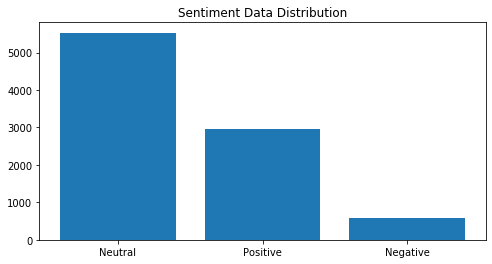

In [806]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

## Word Count

In [807]:
df["word_count"] = df['tweet'].apply(lambda x: len(str(x).split()))

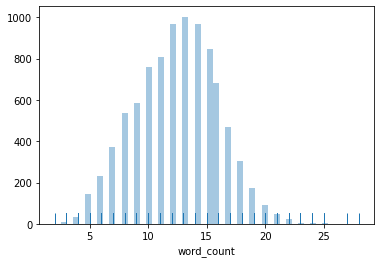

In [808]:
sns.distplot(df.word_count, kde=False, rug=True)

## Word Cloud

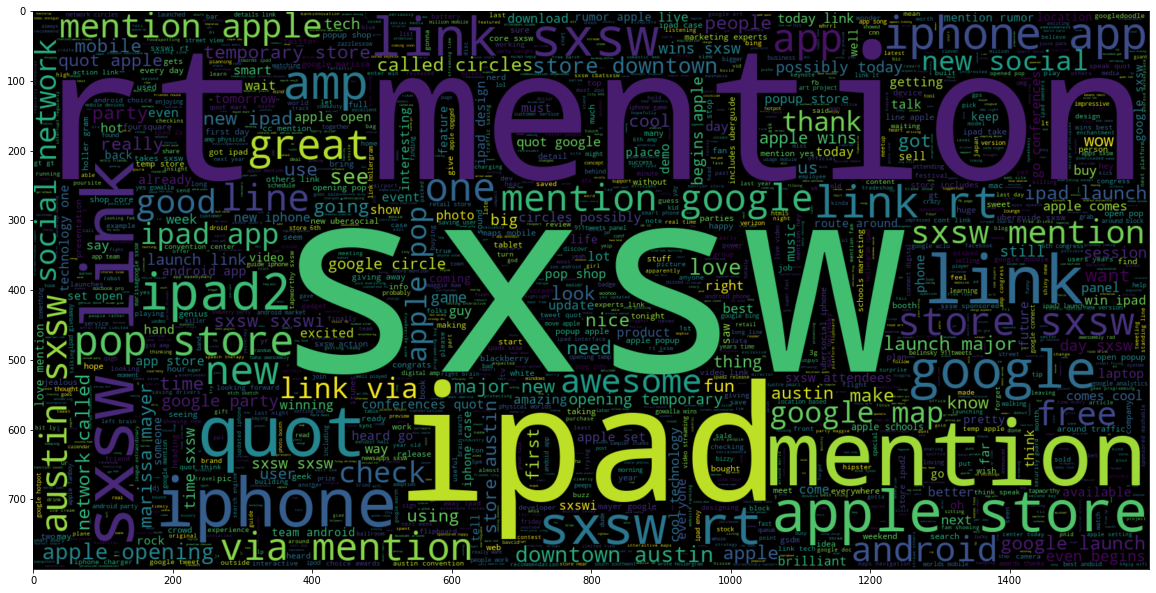

In [809]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].tweet))
plt.imshow(wc , interpolation = 'bilinear')

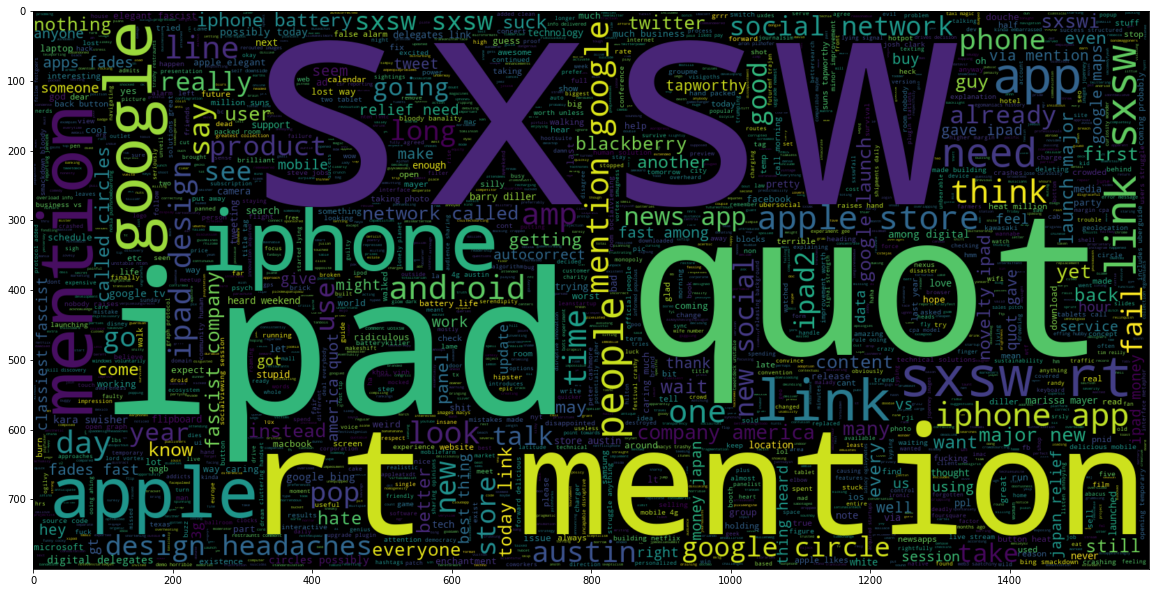

In [810]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].tweet))
plt.imshow(wc , interpolation = 'bilinear')

# Pre-Processing

In [812]:
# Grabbing our inputs and target
X = df['tweet']
y = df['sentiment']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Tokenization

In [813]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 8399


In [814]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (6802, 30)
Testing X Shape: (2268, 30)


## Label Encoding

In [816]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (7274, 1)
y_test shape: (1819, 1)


## Count Vectorizer

In [827]:
# Grabbing our inputs and target
X = df['tweet']
y = df['sentiment']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [828]:
# Intstantiating our vectorizer
count_vectorizer = CountVectorizer()

# Training on the train set, then transforming the train set
X_count_train = count_vectorizer.fit_transform(X_train)
# Transforming the test set
X_count_test = count_vectorizer.transform(X_test)

In [829]:
X_count_train

<6802x8370 sparse matrix of type '<class 'numpy.int64'>'
	with 78248 stored elements in Compressed Sparse Row format>

In [830]:
X_count_test

<2268x8370 sparse matrix of type '<class 'numpy.int64'>'
	with 24959 stored elements in Compressed Sparse Row format>

In [831]:
# Instantiating a classifier to use on this text - Multinomial Naive Bayes
nb_classifier = MultinomialNB()

# Fitting the classifier
nb_classifier.fit(X_count_train, y_train)

# Getting our predictions for the train and test sets
train_preds = nb_classifier.predict(X_count_train)
test_preds = nb_classifier.predict(X_count_test)

Train Accuracy: 0.8212290502793296
Test Accuracy: 0.6768077601410935


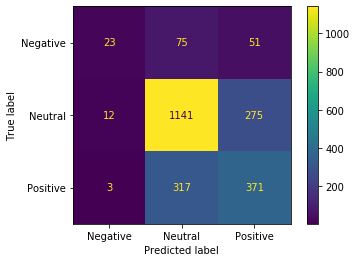

In [832]:
# Let's see how we did!
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
plot_confusion_matrix(nb_classifier, X_count_test, y_test, values_format='.4g')

In [833]:
def classify_vectorized_text(vectorizer, classifier, Xtrain, Xtest, ytrain, ytest):

    Xtrain_transformed = vectorizer.fit_transform(Xtrain)
    Xtest_transformed = vectorizer.transform(Xtest)

    classifier.fit(Xtrain_transformed, ytrain)

    train_preds = classifier.predict(Xtrain_transformed)
    test_preds = classifier.predict(Xtest_transformed)

    print(f"Train Accuracy: {accuracy_score(ytrain, train_preds)}")
    print(f"Test Accuracy: {accuracy_score(ytest, test_preds)}")
    plot_confusion_matrix(classifier, Xtest_transformed, ytest,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

## TFIDF Vectorizer

In [834]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [835]:
# Here, number of rows is the length of our train set
tfidf_train

<6802x4523 sparse matrix of type '<class 'numpy.float64'>'
	with 67608 stored elements in Compressed Sparse Row format>

In [836]:
# Here, number of rows is the length of our test set
tfidf_test

<2268x4523 sparse matrix of type '<class 'numpy.float64'>'
	with 21657 stored elements in Compressed Sparse Row format>

In [837]:
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

# Modeling

Train Accuracy: 0.7565421934725081
Test Accuracy: 0.6829805996472663


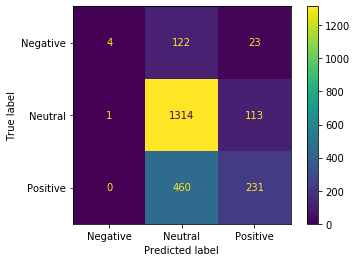

In [900]:
multinomial = MultinomialNB()

# Again, using our function
tfidf_train_preds, tfidf_test_preds = classify_vectorized_text(
    tfidf, multinomial, X_train, X_test, y_train, y_test)

Train Accuracy: 0.9929432519847103
Test Accuracy: 0.7041446208112875


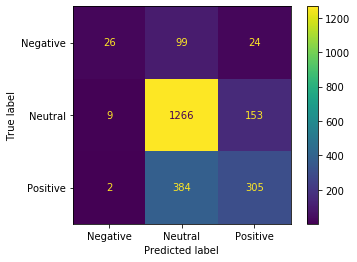

In [901]:
rfc = RandomForestClassifier(n_estimators=100)

rfc_train_preds, rfc_test_preds = classify_vectorized_text(
    tfidf, rfc, X_train, X_test, y_train, y_test)

/Users/cruzisiah/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Accuracy: 0.7980005880623346
Test Accuracy: 0.6940035273368607


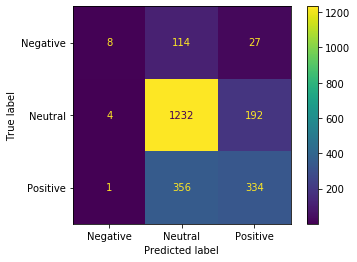

In [907]:
log = LogisticRegression()

log_train_preds, log_test_preds = classify_vectorized_text(
    tfidf, log, X_train, X_test, y_train, y_test)

Train Accuracy: 0.8872390473390179
Test Accuracy: 0.7116402116402116


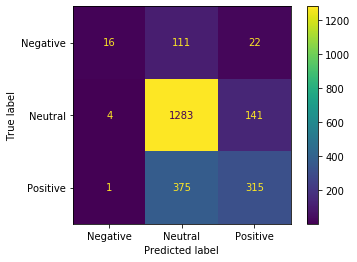

In [903]:
svc = SVC()

svc_train_preds, svc_test_preds = classify_vectorized_text(
    tfidf, svc, X_train, X_test, y_train, y_test)

Train Accuracy: 0.8797412525727727
Test Accuracy: 0.6948853615520282


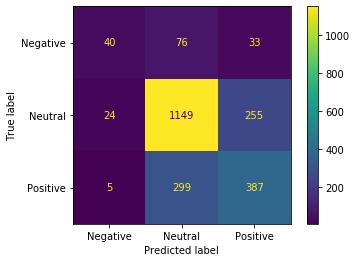

In [904]:
linear_svc = LinearSVC()

linear_svc_train_preds, linear_svc_test_preds = classify_vectorized_text(
    tfidf, linear_svc, X_train, X_test, y_train, y_test)

# Evaluation

In [914]:
print('BEST MODEL: SVC')
print('ACCURACY: 0.711')

BEST MODEL: SVC
ACCURACY: 0.711
